# Bonus1: Parallel Algorithms

### Name: Prathamesh Dilip Bane

## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html


# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [11]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()
y = y.reshape(y.shape[0], 1)

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768, 1)


## 1.2. Feature scaling

In [2]:
 # Standardization
import numpy

    # calculate mu and sig
d = x.shape[1]
mu = numpy.mean(x, axis=0).reshape(1, d)
sig = numpy.std(x, axis=0).reshape(1, d)

    # transform the training features
x = (x - mu) / (sig + 1E-6)

print('mean = ')
print(numpy.mean(x, axis=0))

print('std = ')
print(numpy.std(x, axis=0))

mean = 
[[-5.72458747e-17  1.77953717e-16  1.70761842e-18  9.83009970e-17
   3.46944695e-18  5.12834856e-15  1.88752370e-15  2.17996917e-16]]
std = 
[[0.9999997  0.99999997 0.99999995 0.99999994 0.99999999 0.99999987
  0.99999698 0.99999991]]


In [3]:
n, d = x.shape
x = numpy.concatenate((x, numpy.ones((n, 1))), axis=1)

print('Shape of x: ' + str(x.shape))



Shape of x: (768, 9)


In [4]:
# shuffling data
    # numpy.random.seed(4)
rand_indices = numpy.random.permutation(n)
x = x[rand_indices, :]
y = y[rand_indices, :]

In [5]:
class Worker:
        
    def __init__ (self, x, y):
        self.x = x # s−by−d local feature matrix 
        self.y = y # s−by−1 local label matrix
        self.s = x.shape[0] # number of local samples
        self.d = x.shape[1] # number of features 
        self.w = numpy.zeros((d, 1)) #d−by−1model parameter vector
            
        # Set the model parameters to the latest
        
    def set_param(self , w): 
        self.w = numpy.array(w)
        
        # Compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix 
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(-yxw) # s−by−1 matrix
        vec2 = numpy.log(1 + vec1) # s−by−1 matrix
        return numpy.sum(vec2) # loss function

        # Compute the local gradient
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s−by−d matrix
        yxw = numpy.dot(yx, self.w) # s−by−1 matrix
        vec1 = numpy.exp(yxw) # s−by−1 matrix
        vec2 = numpy.divide(yx, 1+vec1) # s−by−d matrix
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1) # d-by-1 matrix
        return g
        
    def grad_descent(self, stepsize):
        g = self.gradient()
        self.w -= stepsize * g
            
        return self.w
        
    def stochastic_objective_gradient(self, w, xi, yi, lam):
        d = xi.shape[0]
        yx = yi * xi # 1-by-d matrix
        yxw = float(numpy.dot(yx, w)) # scalar

            # calculate stochastic gradient
        g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
        g = g_loss + lam * w # d-by-1 matrix

        return g
        
    def sgd(self, stepsize, lam):
        n = self.x.shape[0]

            # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = self.x[rand_indices, :]
        y_rand = self.y[rand_indices, :]


        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            g = self.stochastic_objective_gradient(self.w, xi, yi, lam)
            self.w -= stepsize * g

            stepsize *= 0.9 # decrease step size
                
            return self.w

In [6]:
import sys
numpy.set_printoptions(threshold=sys.maxsize)

class Server :
    def __init__(self, m, n, d):
        self.m = m # number of worker nodes
        self.n = n # number of training samples
        self.d = d # number of features
        self.w = numpy.zeros((d, 1))# d−by−1 model parameter vector 
        self.loss = 0 # loss function value
        self.obj = 0 # objective function value
        self.g = numpy.zeros((d, 1)) # ascending direction value
        self.v = numpy.zeros((d, 1)) # d−by−1 momentum
            
    def broadcast(self): 
        return self.w
        
        # Sum the gradients and loss functions evaluated by the workers 
        # Args:
        # grads: a list of d−by−1 vectors
        # losses : a list of scalars
    def aggregate(self, grads, losses): 
        self.g = numpy.zeros((self.d, 1)) 
        self.loss=0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
            
        # Compute the gradient (from the loss and regularization )
    def gradient (self, lam) :
        self.g = self.g / self.n + lam * self.w
    #     
        # Compute the objective function (sum of loss and regularization )
    def objective (self, lam) :
        reg = lam / 2 * numpy.sum(self.w * self.w) 
        self.obj = self.loss / self.n + reg
        return self.obj
        
        # Update the model parameters using accelerated gradient descent 
        # Args:
        # alpha: learning rate (step size)
        # beta : momentum parameter
    def agd(self, alpha, beta): 
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

In [7]:
import math

    # Create a server and m worker nodes
def create_server_workers(m, x, y): 
    n, d = x.shape
    s = math.floor(n / m) 
    server = Server(m, n, d) 
    workers = []
        
        # assign training data to each worker
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = Worker(x[indices, :], y[indices, :]) 
        workers.append(worker)
            
    return server, workers

In [8]:
def parallel_calc(q, algo):
    m = 4 # number of worker nodes

    server,workers = create_server_workers(m, x , y)

    lam = 1E-5 # regularization parameter 
    alpha = 1 # learning rate
    beta = 0.9 # momentum parameter
    max_epoch = 300 # number of epochs
    worker_stepsize = 3E-2
    obj_values = []
        
    for t in range(max_epoch): 
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)

# step 2: workers' local computations
        grads = []
        losses = []
            
        for i in range(m): # each worker does local calculation
            for j in range(q): # local GD/SGD for q iterations
                if algo == 'GD':
                    w_t = workers[i].grad_descent(worker_stepsize) 
                else:
                    w_t = workers[i].sgd(worker_stepsize, lam)
                  
            g = w - w_t   
            grads.append(g)
            l = workers[i].loss()
            losses.append(l)

# step 3: aggregate the workers ’ outputs
        server.aggregate(grads, losses)

# step 4: server update the model parameters
        server.gradient(lam) # compute gradient
        obj = server.objective(lam) # compute objective function 
        obj_values.append(obj)
        print('Objective function value = ' + str(obj))
        server.agd(alpha, beta) # updates the model parameters
    return obj_values

In [9]:
print('obj_val_gd_q1: ')
obj_val_gd_q1 = parallel_calc(1, 'GD')
print('obj_val_gd_q8: ')
obj_val_gd_q8 = parallel_calc(8, 'GD')
print('obj_val_sgd_q1: ')
obj_val_sgd_q1 = parallel_calc(1, 'SGD')
print('obj_val_sgd_q8: ')
obj_val_sgd_q8 = parallel_calc(8, 'SGD')

obj_val_gd_q1: 
Objective function value = 0.5294163132019388
Objective function value = 0.5271615803643157
Objective function value = 0.5230007334514789
Objective function value = 0.5173560002242231
Objective function value = 0.5107009089834418
Objective function value = 0.5035322945891526
Objective function value = 0.4963332382477013
Objective function value = 0.48953070190325854
Objective function value = 0.48345694696680114
Objective function value = 0.4783247949972754
Objective function value = 0.474222837131971
Objective function value = 0.4711301144310396
Objective function value = 0.46894414555600084
Objective function value = 0.4675138439440774
Objective function value = 0.4666699025451922
Objective function value = 0.4662481266949536
Objective function value = 0.46610427605785787
Objective function value = 0.4661212058306662
Objective function value = 0.4662102118596735
Objective function value = 0.4663087004225715
Objective function value = 0.4663759939173427
Objective funct

Objective function value = 0.45743537360934744
Objective function value = 0.45743536442527527
Objective function value = 0.45743535565291704
Objective function value = 0.45743534726222773
Objective function value = 0.45743533922447427
Objective function value = 0.4574353315122958
Objective function value = 0.45743532409974935
Objective function value = 0.45743531696234047
Objective function value = 0.4574353100770427
Objective function value = 0.45743530342230154
Objective function value = 0.45743529697803265
Objective function value = 0.4574352907256041
Objective function value = 0.45743528464781524
Objective function value = 0.45743527872886264
Objective function value = 0.4574352729543032
Objective function value = 0.45743526731100864
Objective function value = 0.4574352617871152
Objective function value = 0.4574352563719702
Objective function value = 0.4574352510560731
Objective function value = 0.4574352458310158
Objective function value = 0.4574352406894195
Objective function val

Objective function value = 0.4527521178001873
Objective function value = 0.4527521332815673
Objective function value = 0.4527521473321283
Objective function value = 0.4527521600576046
Objective function value = 0.4527521715574991
Objective function value = 0.4527521819253214
Objective function value = 0.4527521912488289
Objective function value = 0.45275219961026836
Objective function value = 0.45275220708661956
Objective function value = 0.452752213749837
Objective function value = 0.45275221966708923
Objective function value = 0.45275222490099515
Objective function value = 0.45275222950985633
Objective function value = 0.4527522335478842
Objective function value = 0.45275223706542167
Objective function value = 0.45275224010915893
Objective function value = 0.45275224272234194
Objective function value = 0.45275224494497457
Objective function value = 0.45275224681401366
Objective function value = 0.45275224836355565
Objective function value = 0.45275224962501665
Objective function valu

Objective function value = 0.6744858727027251
Objective function value = 0.6767913594407853
Objective function value = 0.6761597430400584
Objective function value = 0.6707872160619118
Objective function value = 0.6724432263144698
Objective function value = 0.6743118340890563
Objective function value = 0.6744293734424528
Objective function value = 0.6743077150523987
Objective function value = 0.6723662095023858
Objective function value = 0.6730307671574027
Objective function value = 0.672041641073809
Objective function value = 0.667960882230463
Objective function value = 0.671377639430385
Objective function value = 0.6771161872452741
Objective function value = 0.6757503821659145
Objective function value = 0.6720793478930858
Objective function value = 0.6695319601600594
Objective function value = 0.6690039420594275
Objective function value = 0.669736654972845
Objective function value = 0.671053701240191
Objective function value = 0.6726826285409756
Objective function value = 0.6736011220

Objective function value = 0.6579708824293247
Objective function value = 0.6527657605891278
Objective function value = 0.6697627121494354
Objective function value = 0.6555257039861199
Objective function value = 0.661226691883458
Objective function value = 0.6517478094883706
Objective function value = 0.652696901197073
Objective function value = 0.6605714693855979
Objective function value = 0.645085568385247
Objective function value = 0.6458203133561745
Objective function value = 0.6497965257117448
Objective function value = 0.6465765620636962
Objective function value = 0.6519740837982732
Objective function value = 0.6507406191802264
Objective function value = 0.6491037498126243
Objective function value = 0.6439303888047168
Objective function value = 0.6470409508442564
Objective function value = 0.6418921242596395
Objective function value = 0.6515704272586862
Objective function value = 0.6457679561769325
Objective function value = 0.6411666309225209
Objective function value = 0.64321038

Objective function value = 0.5379064726124009
Objective function value = 0.538150004239192
Objective function value = 0.5387292584947359
Objective function value = 0.5388280409133736
Objective function value = 0.536768069076962
Objective function value = 0.5349657120484416
Objective function value = 0.5380818052846261
Objective function value = 0.5373238497196194
Objective function value = 0.5367212835349104
Objective function value = 0.5415786153889671
Objective function value = 0.5371106174969578
Objective function value = 0.5332515391316549
Objective function value = 0.5404945904400692
Objective function value = 0.5395123802810939
Objective function value = 0.5363821533045696
Objective function value = 0.536468950784827
Objective function value = 0.534329484421341
Objective function value = 0.5338933927285304
Objective function value = 0.5333600880890186
Objective function value = 0.5322956596903768
Objective function value = 0.5351301418285512
Objective function value = 0.542115258

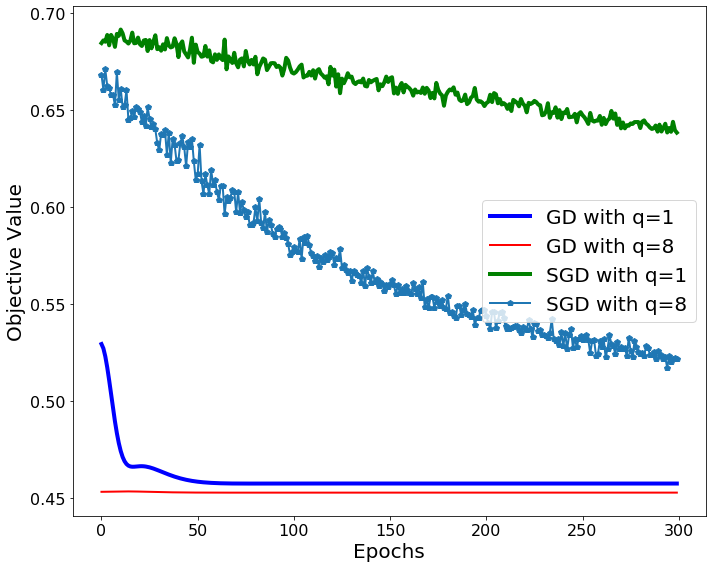

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 8))
epochs_gd_q1 = range(len(obj_val_gd_q1))
epochs_gd_q8 = range(len(obj_val_gd_q8))
epochs_sgd_q1 = range(len(obj_val_sgd_q1))
epochs_sgd_q8 = range(len(obj_val_sgd_q8))

line0, = plt.plot(epochs_gd_q1, obj_val_gd_q1, '-b', LineWidth=4)
line1, = plt.plot(epochs_gd_q8, obj_val_gd_q8, '-r', LineWidth=2)
line2, = plt.plot(epochs_sgd_q1, obj_val_sgd_q1, '-g', LineWidth=4)
line3, = plt.plot(epochs_sgd_q8, obj_val_sgd_q8, '-p', LineWidth=2)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD with q=1', 'GD with q=8', 'SGD with q=1', 'SGD with q=8'], fontsize=20)
# plt.legend([line1], ['GD with q=8'], fontsize=20)

plt.tight_layout()
plt.show()